In [46]:
def entroplots(ref_study):
    import spikeextractors as se
    import kachery as ka
    ka.set_config(fr='default_readonly')
    import sys, time
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.neighbors import KernelDensity
    from pyentropy import DiscreteSystem
    import scipy.stats as stats
    SF = ka.load_object('sha1://1667383039f1170256e4e3445d46eff367e202e5/output.json', fr='default_readonly')
    sorting_results = SF['SortingResults']
    len(sorting_results[0]),len(sorting_results)
    firings_path = ka.load_file(sorting_results[0]['firings'])
    sorting = se.MdaSortingExtractor(firings_path)
    ii = []
    for i in sorting_results:
        ii.append(i['studyName'])
    ii = np.array(ii)
    
    def calculate_entropies_counts(sorting, method, sampling_frequency, binSec=0.5):
        output = np.zeros((len(sorting.get_unit_ids())))

        sampF = sampling_frequency
        unit_ids = sorting.get_unit_ids()
        fr = np.zeros(len(unit_ids))
        isi = [[] for uid in unit_ids]
        spike_trains = [sorting.get_unit_spike_train(unit_id=uid) for uid in unit_ids]
        maxT = np.max([np.max(st) for st in spike_trains]) / sampling_frequency
        for ii, unit_id in enumerate(unit_ids):
            spk = spike_trains[ii]
            fr[ii] = len(spk)/maxT
            isi[ii] = np.diff(spk)/sampF
            binSize = binSec * sampF 
            bins = np.arange(0, maxT*sampF, binSize)
            spkCount,_ = np.histogram(spk, bins)

            xm = np.max(spkCount)+1
            sys = DiscreteSystem(spkCount.astype(int), (1,xm), spkCount, (1,xm))        
            if method == 'plugin':
                sys.calculate_entropies(method='plugin', calc=['HX'])
                output[ii] = sys.H_plugin['HX']
            elif method == 'pt':
                sys.calculate_entropies(method='pt', calc=['HX'])
                output[ii] = sys.H_pt['HX']
            elif method == 'qe':
                sys.calculate_entropies(method='qe', calc=['HX'])
                output[ii] = sys.H_qe['HX']
            #elif method == 'CDM':
                #output[ii] = eng.entropyCDM(matlab.double(spkCount.tolist()), 0)
        return output, fr, isi

    def poisson_spk_entropy(fr,binSec,N):
        x = np.random.poisson(fr*binSec,N)
        xm = np.max(x)+1
        sys = DiscreteSystem(x.astype(int), (1,xm), x, (1,xm))
        sys.calculate_entropies(method='pt', calc=['HX'])
        return sys.H_pt['HX']

    def run_poisson_spkH_samples(fr,binSec,N,R):
        out = np.zeros(R)
        for r in range(R):
            out[r] = poisson_spk_entropy(fr,binSec,N)
        return np.mean(out)
    
    sorters_ = []; recs = []
    for i in sorting_results:
        if i['studyName']==ref_study:
            sorters_.append(i['sorterName'])
            recs.append(i['recordingName'])
    sorters_ = np.asarray(sorters_)
    sorters = np.unique(sorters_)
    recs_names = np.unique(recs)
    
    output_sort_c = {} #dictionary
    bias = ['pt'] #list - better
    FR_c = {}; ISI_c = {}
    for y in bias:
        all_methods = {k:{} for k in sorters}
        fr = {k:{} for k in sorters}
        isi = {k:{} for k in sorters}
        for k in sorters:
            all_methods[k] = {kk:[] for kk in recs_names}
            fr[k] = {kk:[] for kk in recs_names}
            isi[k] = {kk:[] for kk in recs_names}
        for x in range(len(sorting_results)):
            if sorting_results[x]['studyName']==ref_study:
                try:
                    firings_path = ka.load_file(sorting_results[x]['firings'])
                    sort_temp = sorting_results[x]['sorterName']
                    rec_temp = sorting_results[x]['recordingName']
                    sorting = se.MdaSortingExtractor(firings_path)
                    all_methods[sort_temp][rec_temp], fr[sort_temp][rec_temp], isi[sort_temp][rec_temp] =\
                        calculate_entropies_counts(sorting, method=y, sampling_frequency=30000,
                                           binSec=0.5)
                except:
                    a=1
        output_sort_c[y]= all_methods
        FR_c[y] = fr; ISI_c[y] = isi
    
    HF_counts = {} #dictionary
    bias = ['pt'] #list - better
    binL = 0.5

    for y in bias:
        temp_out = {k:{} for k in sorters}
        for k in sorters:
            temp_out[k] = {kk:[] for kk in recs_names}
        for x in range(len(sorting_results)):
            if sorting_results[x]['studyName']==ref_study:
                try:
                    firings_path = ka.load_file(sorting_results[x]['firings'])
                    sort_temp = sorting_results[x]['sorterName']
                    rec_temp = sorting_results[x]['recordingName']
                    sorting = se.MdaSortingExtractor(firings_path)
                    for i in range(len(output_sort_c[y][sort_temp][rec_temp])):
                        nSpike = len(ISI_c[y][sort_temp][rec_temp][i])+1;
                        FR_spk = FR_c[y][sort_temp][rec_temp][i];
                        H_poiss = run_poisson_spkH_samples(FR_spk,binL,nSpike,10)                    
                        temp_out[sort_temp][rec_temp].append(output_sort_c[y][sort_temp][rec_temp][i]/H_poiss)                                        
                except:
                    a=1
        HF_counts[y] = temp_out

    binsLog = np.logspace(-2,2,15)
    b = 'pt'
    toP = {k:[] for k in sorters}
    toP2 = {k:[] for k in sorters}
    meanHF = {k:[] for k in sorters}
    semHF = {k:[] for k in sorters}
    for s in sorters:
        for rr in recs_names:
            toP[s].extend(np.asarray(HF_counts[b][s][rr]))
            toP2[s].extend(np.asarray(FR_c[b][s][rr]))
    bins = np.linspace(0,10,10)
    ri = 1 # recording index
    for n,s in enumerate(sorters):
        for bi in range(len(binsLog)-1):
            temp = np.asarray(toP[s])[(toP2[s]>binsLog[bi]) & (toP2[s]<=binsLog[bi+1])]
            temp = temp[~np.isinf(temp)]
            meanHF[s].append(np.nanmean(temp))
            semHF[s].append(stats.sem(temp, nan_policy='omit'))
        meanHF[s] = np.asarray(meanHF[s])
        semHF[s] = np.asarray(semHF[s])

    plt.figure(figsize=[15,10])
    x2p = [(binsLog[i]+binsLog[i+1]) / 2 for i in range(len(binsLog)-1)]
    for s in sorters:
        plt.plot(x2p, meanHF[s], label=s)
        plt.fill_between(x2p,meanHF[s]-semHF[s], meanHF[s]+semHF[s], alpha=.2)
    plt.legend()
    plt.xscale('log')
    plt.hlines(1,x2p[0],x2p[-1],'k',linestyle='--')
    plt.xlim(x2p[0], x2p[-1])
    plt.xlabel('Binned FR [Hz]')
    plt.ylabel('HF [bits]')
    return

/Users/martyna/.local/lib/python3.7/site-packages/pyentropy/systems.py:574: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if (not np.issubdtype(X.dtype, np.int)) \


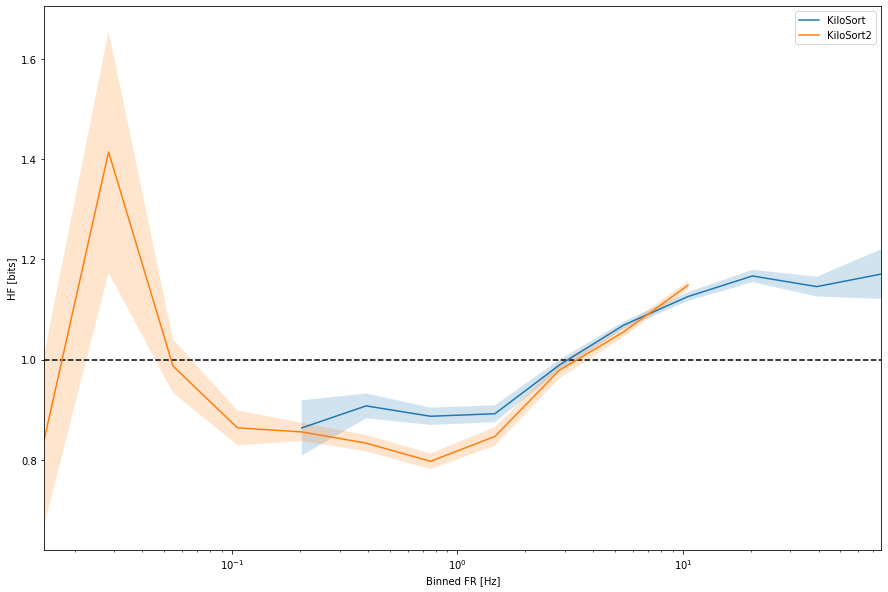

In [47]:
entroplots('paired_english')